In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tailor

### Create initial DataFrame

In [2]:
raw_df = tailor.load_data()
raw_df.article_id = raw_df.article_id.astype(int)
df_revenue = raw_df[['article_id', 'time_on_sale', 'revenue']]

To give an example, the dataframe looks like this ...

In [3]:
df_revenue.head()

,article_id,time_on_sale,revenue
0,900001,0,1304.90
1,900001,1,2332.61
2,900001,2,1891.40
3,900001,3,1596.69
4,900001,4,2026.30


### Create a Benchmark Series

Now reshape the dataframes into a format which makes it easier to calculate the mean of each time_on_sale value.  The following steps must be done for each  performance measure.  For now, we will just do it for the dataframe with the column 'revenue' (df_revenue)



In [4]:
df_pivoted = df_revenue.pivot_table(
    values='revenue', index='article_id', columns='time_on_sale')
# cast pivot table into DataFrame
df_reshaped = pd.DataFrame(df_pivoted.to_records())
df_reshaped.head()

,article_id,0,1,2,3,4,5,6,7,8,...,16,17,18,19,20,21,22,23,24,25
0,900001,1304.90,2332.61,1891.40,1596.69,2026.30,1594.66,3159.35,1946.54,2096.92,...,2307.90,2374.16,2688.67,2407.42,1965.51,1550.48,1474.78,1130.60,979.50,528.10
1,900002,919.81,2196.22,2399.59,3429.65,3967.15,2828.35,3578.87,3163.93,3082.90,...,1810.07,1233.06,1477.83,1374.52,1369.21,1294.49,1114.56,996.45,555.50,1760.73
2,900003,986.41,1536.07,1655.66,1667.59,2353.29,1982.85,1553.00,2887.61,2391.06,...,4246.41,3039.98,2544.63,2534.42,2045.05,1724.20,1544.24,959.94,440.76,382.46
3,900004,349.56,1198.40,843.05,1469.16,1637.85,970.61,1547.80,1628.52,1527.21,...,1245.73,1180.15,1429.02,1370.24,1162.19,376.72,448.83,99.25,206.49,132.15
4,900005,633.27,624.44,966.20,1460.34,931.49,747.31,1501.67,674.78,803.48,...,926.23,1134.26,1951.15,1229.48,967.71,580.24,276.79,210.34,287.28,256.85


Next, calculate the mean of each column. Therefore, you have the mean for each time_on_sale value. This series can be used as a benchmark series. 

In [5]:
revenue_benchmark = df_reshaped.mean(axis=0)
revenue_benchmark.head()

article_id    904354.500000
0                843.484325
1               1416.730330
2               1651.588335
3               1820.432671
dtype: float64

Drop mean of article ids. It makes no sense and we dont need it 

In [6]:
revenue_benchmark = revenue_benchmark.drop(revenue_benchmark.index[0])
revenue_benchmark.head()

0     843.484325
1    1416.730330
2    1651.588335
3    1820.432671
4    1954.158853
dtype: float64

Cast series into a DataFrame

In [7]:
df_revenue_benchmark = pd.DataFrame()
df_revenue_benchmark['time_on_sale'] = revenue_benchmark.keys().astype(int)
df_revenue_benchmark['mean_revenue'] = revenue_benchmark.values
df_revenue_benchmark.head()

,time_on_sale,mean_revenue
0,0,843.484325
1,1,1416.730330
2,2,1651.588335
3,3,1820.432671
4,4,1954.158853


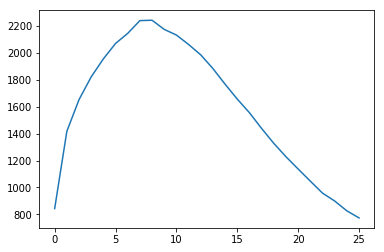

In [8]:
plt.plot(df_revenue_benchmark.time_on_sale, df_revenue_benchmark.mean_revenue);

### Calculate distance to Benchmark Series

Merging both DataFrames yields in ...

In [9]:
result = pd.merge(df_revenue, df_revenue_benchmark, how='left', on='time_on_sale',
                  left_index=False, right_index=True, sort=True, validate='m:1')
result = result.reset_index()
result = result.drop('index', axis=1)
result = result.rename(index=str, columns={'mean_revenue_y': 'mean_revenue'})
result.head()

,article_id,time_on_sale,revenue,mean_revenue
0,900001,0,1304.90,843.484325
1,900002,0,919.81,843.484325
2,900003,0,986.41,843.484325
3,900004,0,349.56,843.484325
4,900005,0,633.27,843.484325


Calculate the distance between revenue and mean_revenue

In [10]:
result['distance'] = ((result['revenue'] - result['mean_revenue'])**2)**0.5
result.head()

,article_id,time_on_sale,revenue,mean_revenue,distance
0,900001,0,1304.90,843.484325,461.415675
1,900002,0,919.81,843.484325,76.325675
2,900003,0,986.41,843.484325,142.925675
3,900004,0,349.56,843.484325,493.924325
4,900005,0,633.27,843.484325,210.214325


Sum up all distances to get just one value for similiarity measurement

In [11]:
result = result.groupby('article_id').sum()
result = result.reset_index()
result = result.drop(['revenue', 'mean_revenue'], axis=1)
result.head()

,article_id,time_on_sale,distance
0,900001,325,15656.700141
1,900002,325,16158.096740
2,900003,325,29235.138465
3,900004,325,16217.584298
4,900005,325,17682.746935


In [12]:
result = result.sort_values('distance', ascending=True)
result.head()

,article_id,time_on_sale,distance
534,900535,325,5669.539319
30,900031,325,6691.160194
5272,905273,325,6849.600752
3101,903102,325,7379.004553
3252,903253,325,7413.771494


### First evaluation of the similarity measurement

Plot the two article with the lowest distance 

In [13]:
lowest_distance = result.iloc[0]
second_lowest_distance = result.iloc[1]
df_revenue_lowest = df_revenue[df_revenue['article_id']
                               == lowest_distance.article_id]
df_revenue_second_lowest = df_revenue[df_revenue['article_id']
                                      == second_lowest_distance.article_id]

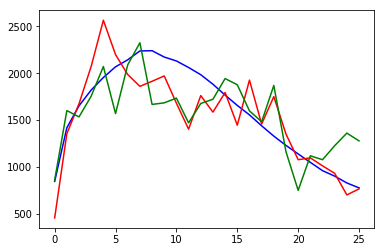

In [14]:
plt.plot(df_revenue_benchmark.time_on_sale,
         df_revenue_benchmark.mean_revenue, 'b')
plt.plot(df_revenue_lowest.time_on_sale, df_revenue_lowest.revenue, 'r')
plt.plot(df_revenue_second_lowest.time_on_sale,
         df_revenue_second_lowest.revenue, 'g');

Let us plot some articles with similiar distances. To find similiar values, I just had a look at the sorted result dataframe

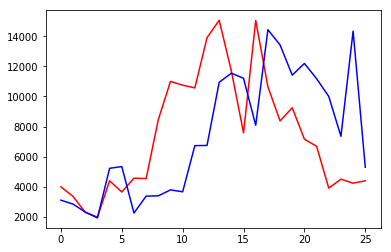

In [15]:
article_one = raw_df[raw_df['article_id'] == 902792]
article_two = raw_df[raw_df['article_id'] == 901825]

plt.plot(article_one['time_on_sale'], article_one['revenue'], 'r')
plt.plot(article_two['time_on_sale'], article_two['revenue'], 'b');

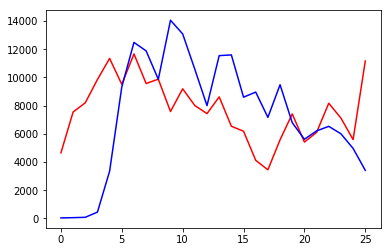

In [16]:
article_three = raw_df[raw_df['article_id'] == 900546]
article_four = raw_df[raw_df['article_id'] == 906171]

plt.plot(article_three['time_on_sale'], article_three['revenue'], 'r')
plt.plot(article_four['time_on_sale'], article_four['revenue'], 'b');